In [1]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [2]:
keywords = pd.read_csv('keywords_preprocessed.csv')
meta = pd.read_csv('movies_metadata_preprocessed.csv')
ratings = pd.read_csv('ratings_preprocessed.csv')

In [3]:
df_numeric = meta[['budget','popularity','revenue','runtime','vote_average','vote_count']]
df_numeric.dropna(inplace=True)

train,test = train_test_split(df_numeric,test_size=0.25)

/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
x = train.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_numeric.columns

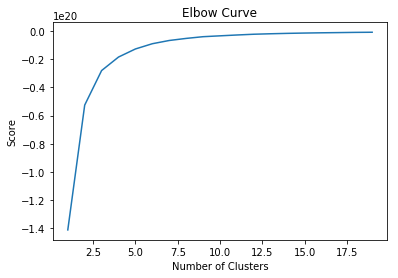

In [5]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
y = np.array(train.revenue).reshape(-1,1)
score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit(y).predict(y)
train['cluster'] = kmeans.labels_


/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
[len(train[train.cluster==i]) for i in range(4)]

[31911, 77, 279, 1233]

In [8]:
[train[train.cluster==i].revenue.mean() for i in range(4)]

[8731398.221428314, 942624097.3116883, 396458628.53978497, 125251626.40486614]

In [9]:
train.groupby(['cluster']).mean()

,budget,popularity,revenue,runtime,vote_average,vote_count
cluster,,,,,,
0,5.370484e+06,2.431157,8.731398e+06,92.992761,5.608141,46.523863
1,1.595584e+08,47.124514,9.426241e+08,132.012987,6.976623,5620.467532
2,9.563989e+07,17.686951,3.964586e+08,118.086022,6.593548,2624.182796
3,4.307709e+07,10.589928,1.252516e+08,118.708840,6.303974,871.671533


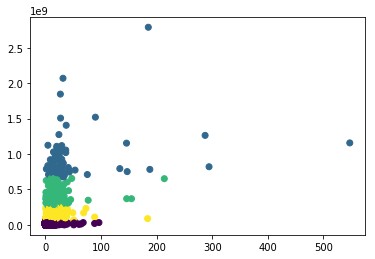

In [10]:
size_array = list(train.groupby(['cluster']).count()['revenue'].values)
train[train['cluster']==size_array.index(sorted(size_array)[0])].revenue.mean()
plt.scatter(train.popularity,train.revenue,c=kmeans.labels_)
plt.show()

In [11]:
cluster1 = train[train.cluster==1]
cluster1 = cluster1[cluster1.revenue!=0]
len(cluster1)

77

In [12]:
test_clusters = kmeans.predict(test.revenue.values.reshape(-1,1))
test['cluster'] = test_clusters
print(train.groupby(['cluster']).mean())
print(test.groupby(['cluster']).mean())

               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        5.370484e+06    2.431157  8.731398e+06   92.992761      5.608141   
1        1.595584e+08   47.124514  9.426241e+08  132.012987      6.976623   
2        9.563989e+07   17.686951  3.964586e+08  118.086022      6.593548   
3        4.307709e+07   10.589928  1.252516e+08  118.708840      6.303974   

          vote_count  
cluster               
0          46.523863  
1        5620.467532  
2        2624.182796  
3         871.671533  
               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        5.433621e+06    2.422613  8.674219e+06   93.036211      5.583719   
1        1.670200e+08   36.939711  9.523766e+08  129.040000      7.024000   
2        9.375633e+07   15.420608  3.809855e+08  117.126214      6.610680   
3        4.456

/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


34387915.90521913


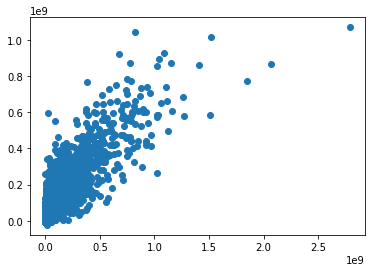

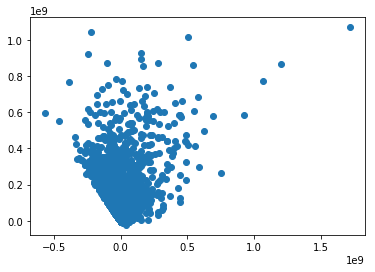

0.7192730102094451


In [33]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

train['new'] = train['vote_average']*np.power(train['vote_count'],0.8)

X = train[['budget','popularity','runtime','new']]
y = train[['revenue']]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
pred = pd.DataFrame(predictions,columns=["revenue"])
y['revenue_pred'] = predictions
# y = y[y.revenue_pred>0]

# log_y = np.log10(y.revenue)
# log_y_pred = np.log10(y.revenue_pred)
# print(mean_squared_error(log_y,log_y_pred))

print((mean_squared_error(y.revenue,y.revenue_pred))**0.5)


residuals = y.revenue - y.revenue_pred
plt.scatter(y.revenue,y.revenue_pred)
plt.show()
plt.scatter(residuals,y.revenue_pred)
plt.show()

print(model.score(X,y.revenue))

budget


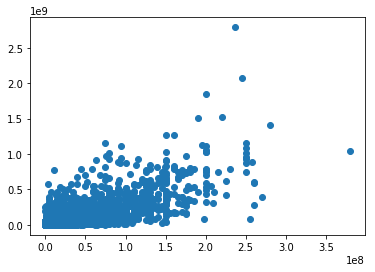

popularity


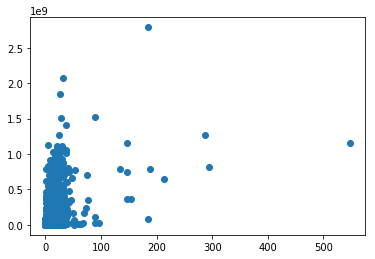

runtime


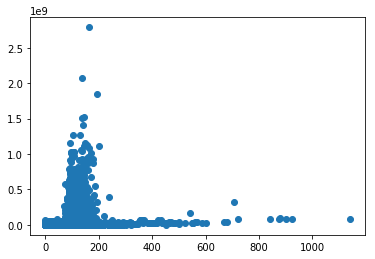

new


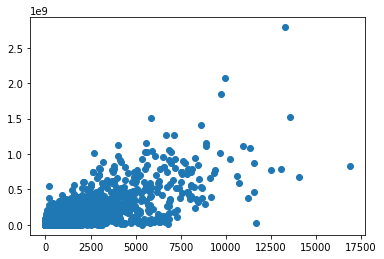

In [29]:
for i in X:
    plt.scatter(X[i],train['revenue'])
    print(i)
    plt.show()